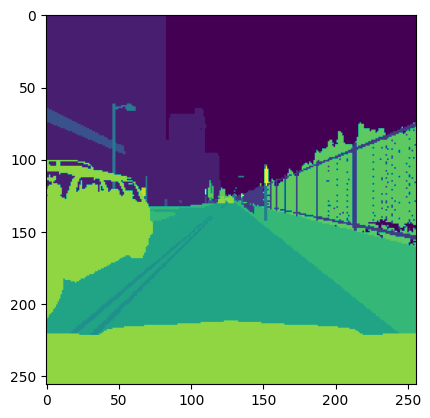

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


img_path = "/kaggle/input/cv-a4-q2/dataset_256/train/images/02_00_000.png"
label_path = "/kaggle/input/cv-a4-q2/dataset_256/train/labels/02_00_000.png"

mask = cv2.imread(label_path)
plt.imshow(mask[:,:,2])


In [2]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Data(Dataset):
    def __init__(self, root_dir, transform=None):

        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.image_filenames = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
        self.label_filenames = sorted([f for f in os.listdir(self.label_dir) if f.endswith('.png')])

        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = cv2.imread(img_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        label_path = os.path.join(self.label_dir, self.label_filenames[idx])
        mask = cv2.imread(label_path) 
        mask = mask[:,:,2]

        if self.transform:
            image = self.transform(image)


        mask = torch.tensor(mask, dtype=torch.long) 

        return image, mask

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [3]:

batch_size = 16

dataset = Data(root_dir="/kaggle/input/cv-a4-q2/dataset_256/train", transform=transform)

train_size = int(0.75 * len(dataset))

val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

test_dataset = Data(root_dir="/kaggle/input/cv-a4-q2/dataset_256/test", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


len(dataset)

2000

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:

import torch.nn as nn

class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualConvBlock, self).__init__()
        
       
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # Skip connection
        self.skip_connection = nn.Sequential()
        if in_channels != out_channels:
            # 1x1 convolution 
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        residual = self.skip_connection(x)
        out = self.conv_block(x)
        out += residual 
        out = self.relu(out)
        return out

class UNet_Residual(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(UNet_Residual, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder 
        self.encoder_1 = ResidualConvBlock(in_channels, 64) 
        self.encoder_2 = ResidualConvBlock(64, 128)         
        self.encoder_3 = ResidualConvBlock(128, 256)        
        self.encoder_4 = ResidualConvBlock(256, 512)         

        # Bottleneck
        self.bottleneck = ResidualConvBlock(512, 1024)

        # Decoder 
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        self.decoder_1 = ResidualConvBlock(1024, 512)  # 512+512 input

        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.decoder_2 = ResidualConvBlock(512, 256)  # 256+256 input

        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.decoder_3 = ResidualConvBlock(256, 128)  # 128+128 input

        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.decoder_4 = ResidualConvBlock(128, 64)  # 64+64 input

        self.output = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        # Encoder 
        enc1 = self.encoder_1(x)
        x = self.max_pool2d(enc1)
        
        enc2 = self.encoder_2(x)
        x = self.max_pool2d(enc2)
        
        enc3 = self.encoder_3(x)
        x = self.max_pool2d(enc3)
        
        enc4 = self.encoder_4(x)
        x = self.max_pool2d(enc4)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder 
        x = self.up_transpose_1(x)
        x = self.decoder_1(torch.cat([enc4, x], dim=1))
        
        x = self.up_transpose_2(x)
        x = self.decoder_2(torch.cat([enc3, x], dim=1))
        
        x = self.up_transpose_3(x)
        x = self.decoder_3(torch.cat([enc2, x], dim=1))
        
        x = self.up_transpose_4(x)
        x = self.decoder_4(torch.cat([enc1, x], dim=1))
        
        return self.output(x)

In [6]:
import torch.optim as optim
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import torchmetrics
from torchmetrics.segmentation import MeanIoU

BATCH_SIZE = 5
LEARNING_RATE = 0.001
NUM_EPOCHS = 24
NUM_CLASSES = 13
IMAGE_SIZE = 256

model = UNet_Residual(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

val_miou = MeanIoU(num_classes=NUM_CLASSES).to(device)
test_miou = MeanIoU(num_classes=NUM_CLASSES).to(device)


In [7]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
  
    
    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
    
    
    
    return epoch_loss / len(loader)

In [8]:
def validate(model, loader, criterion, miou_metric, device):
    model.eval()
    val_loss = 0
    miou_metric.reset()  
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            miou_metric.update(preds, masks)
    
    epoch_miou = miou_metric.compute()
    
    return val_loss / len(loader), epoch_miou.item()

In [9]:
def test(model, loader, miou_metric, device):
    model.eval()
    miou_metric.reset() 
    all_images = []
    all_masks = []
    all_predictions = []
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Testing"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
       
            miou_metric.update(predictions, masks)
            
            
            if len(all_images) < 5: 
                all_images.extend(images.cpu())
                all_masks.extend(masks.cpu())
                all_predictions.extend(predictions.cpu())
    
   
    final_miou = miou_metric.compute().item()
    
    sample_images = torch.stack(all_images[:5])
    sample_masks = torch.stack(all_masks[:5])
    sample_predictions = torch.stack(all_predictions[:5])
    
    return final_miou, sample_images, sample_masks, sample_predictions


In [10]:
def visualize_results(images, masks, predictions):
    """Visualize the results"""
    fig, axes = plt.subplots(len(images), 3, figsize=(12, 4*len(images)))
    
    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    for i in range(len(images)):
        # Original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * std.permute(1, 2, 0).cpu().numpy() + mean.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        # Ground truth mask
        mask = masks[i].cpu().numpy()
        axes[i, 1].imshow(mask, cmap='tab20')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        # Predicted mask
        pred = predictions[i].cpu().numpy()
        axes[i, 2].imshow(pred, cmap='tab20')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [11]:
def train_model():
    best_model_path = "best_unetvanilla_model.pth"

    os.makedirs("results", exist_ok=True)
    
    train_losses = []
    val_losses = []
    val_mious = []
    
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        

        train_loss= train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_epoch_miou = validate(model, val_loader, criterion, val_miou, device)
        

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        val_mious.append(val_epoch_miou)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val mIoU: {val_epoch_miou:.4f}")
        
  
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_mious, label='Val mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_model_path



Training started
Epoch 1/24


Validation: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


Train Loss: 0.5603
Val Loss: 0.4288, Val mIoU: 0.7338
Epoch 2/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Train Loss: 0.2390
Val Loss: 0.2529, Val mIoU: 0.8061
Epoch 3/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Train Loss: 0.1884
Val Loss: 0.2529, Val mIoU: 0.8072
Epoch 4/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Train Loss: 0.1606
Val Loss: 0.1527, Val mIoU: 0.8511
Epoch 5/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Train Loss: 0.1298
Val Loss: 0.1265, Val mIoU: 0.8645
Epoch 6/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train Loss: 0.1134
Val Loss: 0.1075, Val mIoU: 0.8749
Epoch 7/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Train Loss: 0.1047
Val Loss: 0.1553, Val mIoU: 0.8467
Epoch 8/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Train Loss: 0.1038
Val Loss: 0.1121, Val mIoU: 0.8686
Epoch 9/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Train Loss: 0.0847
Val Loss: 0.0854, Val mIoU: 0.8865
Epoch 10/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Train Loss: 0.0751
Val Loss: 0.0797, Val mIoU: 0.8910
Epoch 11/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Train Loss: 0.0682
Val Loss: 0.0717, Val mIoU: 0.8935
Epoch 12/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Train Loss: 0.0660
Val Loss: 0.0757, Val mIoU: 0.8929
Epoch 13/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


Train Loss: 0.0580
Val Loss: 0.0594, Val mIoU: 0.8989
Epoch 14/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Train Loss: 0.0524
Val Loss: 0.0627, Val mIoU: 0.9000
Epoch 15/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


Train Loss: 0.0519
Val Loss: 0.0604, Val mIoU: 0.9001
Epoch 16/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Train Loss: 0.0494
Val Loss: 0.0555, Val mIoU: 0.9021
Epoch 17/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Train Loss: 0.0464
Val Loss: 0.0512, Val mIoU: 0.9050
Epoch 18/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Train Loss: 0.0406
Val Loss: 0.0488, Val mIoU: 0.9066
Epoch 19/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Train Loss: 0.0391
Val Loss: 0.0506, Val mIoU: 0.9054
Epoch 20/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Train Loss: 0.0377
Val Loss: 0.0461, Val mIoU: 0.9065
Epoch 21/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train Loss: 0.0348
Val Loss: 0.0447, Val mIoU: 0.9072
Epoch 22/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train Loss: 0.0328
Val Loss: 0.0411, Val mIoU: 0.9107
Epoch 23/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Train Loss: 0.0329
Val Loss: 0.0669, Val mIoU: 0.8985
Epoch 24/24


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Train Loss: 0.1800
Val Loss: 0.1549, Val mIoU: 0.8520


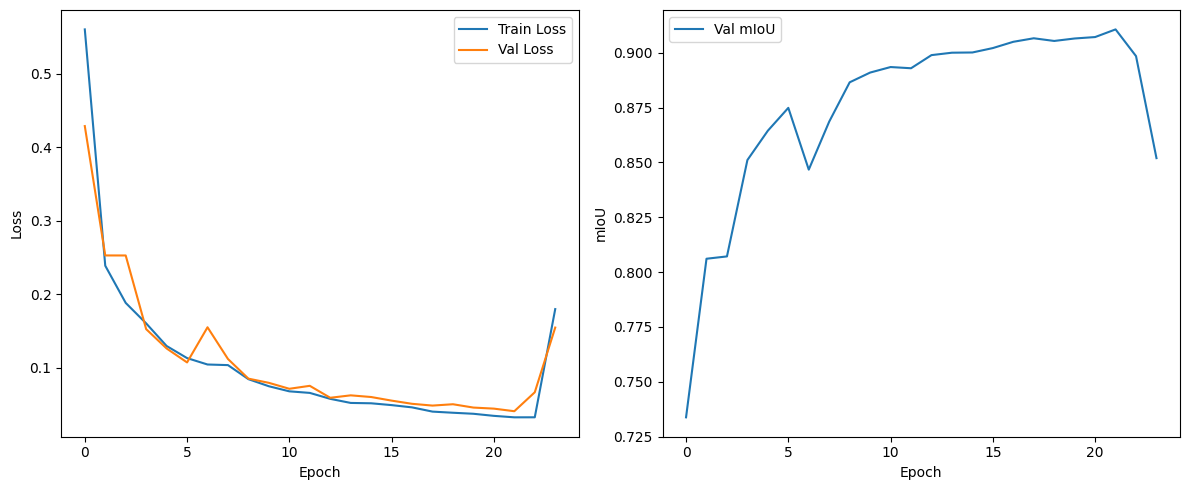

Training completed


Testing: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Test mIoU: 0.8523


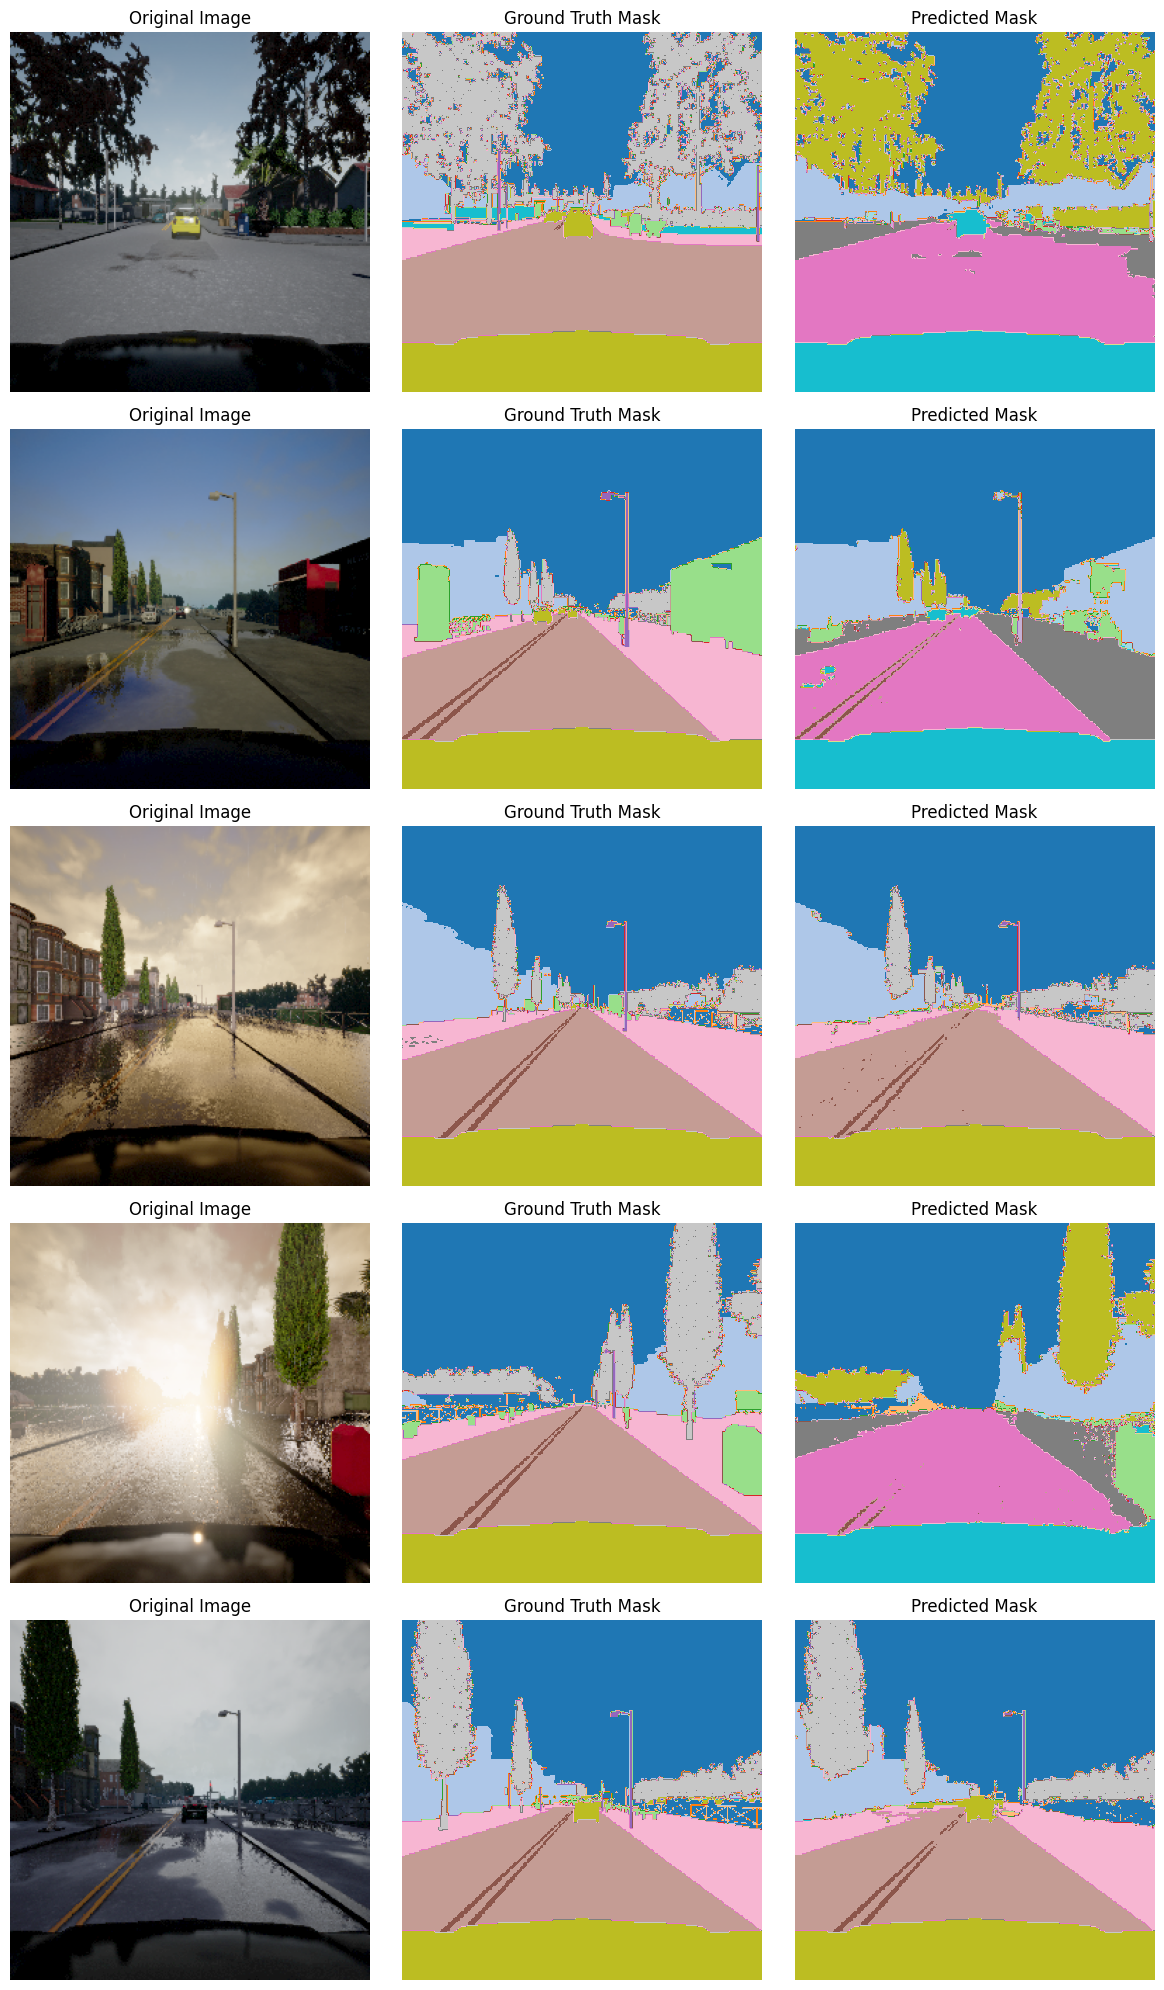

In [12]:


print(f"Training started")
best_model_path = train_model()
print(f"Training completed")

test_epoch_miou, sample_images, sample_masks, sample_predictions = test(model, test_loader, test_miou, device)
print(f"Test mIoU: {test_epoch_miou:.4f}")

visualize_results(sample_images, sample_masks, sample_predictions)
 